# Guided exercise: Energy Transport

In this guided exercise we will revisit the energy balance, this time with ERA5 data instead of CERES. The main novelty of this lesson is **the computation of the meridional energy transport** from the TOA, using the numerical methods we learned last week. The code is on me, the questions are on you! Like always, I recommend to download this notebook and run it by yourself instead of reading it online.

In [1]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## Data 

We are going to work with a new file: [ERA5_LowRes_AnnualAvg_4D_eb.nc](https://cluster.klima.uni-bremen.de/~fmaussion/teaching/climate/ERA5_LowRes_AnnualAvg_4D_eb.nc)

In [5]:
ds = xr.open_dataset('../data/ERA5_LowRes_AnnualAvg_eb.nc')

**Q: explore the data file. Some variables of the surface and TOA energy balance are missing, but they can be retrieved from the others: which ones?**

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241)
Coordinates:
  * longitude  (longitude) float32 -179.6 -178.9 -178.1 ... 178.1 178.9 179.6
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Data variables:
    slhf       (latitude, longitude) float64 ...
    sshf       (latitude, longitude) float64 ...
    ssr        (latitude, longitude) float64 ...
    str        (latitude, longitude) float64 ...
    ssrd       (latitude, longitude) float64 ...
    strd       (latitude, longitude) float64 ...
    tisr       (latitude, longitude) float64 ...
    tsr        (latitude, longitude) float64 ...
    ttr        (latitude, longitude) float64 ...

## Energy balance at the TOA

We'll now compute the energy balance $E_{TOA}$ at the top of the atmosphere (TOA), as well as its global average:

In [7]:
# constants
dx_rad = np.deg2rad(0.75)
coslat = np.cos(np.deg2rad(ds.latitude))
w = coslat / np.sum(coslat)
r = 6371000

In [8]:
eb_toa = ds.tsr + ds.ttr

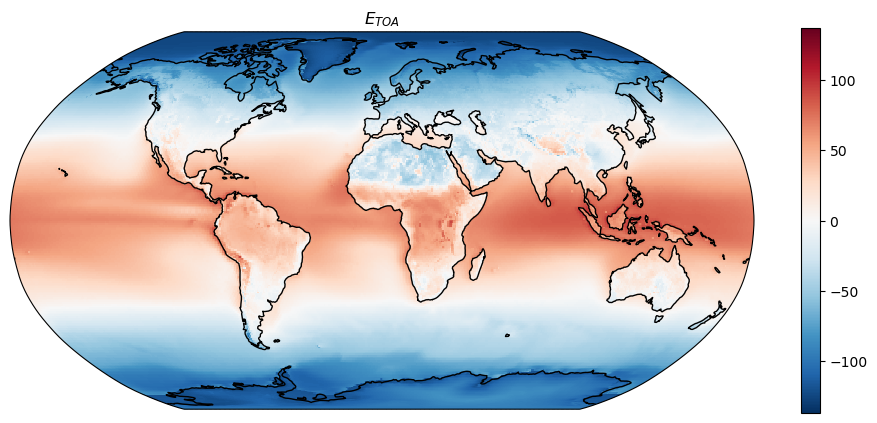

In [9]:
ax = plt.axes(projection=ccrs.Robinson())
eb_toa.plot(ax=ax, transform=ccrs.PlateCarree())
plt.title('$E_{TOA}$')
ax.coastlines();

In [10]:
print('Incoming solar energy TOA: {:.0f} W m-2'.format((ds.tisr.mean(dim='longitude') * w).sum().data))
print('Average E TOA: {:.2f} W m-2'.format((eb_toa.mean(dim='longitude') * w).sum().data))

Incoming solar energy TOA: 340 W m-2
Average E TOA: 0.44 W m-2


**Q: Is the energy budget for the total climate system balanced? Should it be? Compare the ERA5 radiative balance to [the one we obtained with CERES data](https://fabienmaussion.info/climate_system/week_02/01_Lesson_NetCDF_Data.html#arithmetics-and-averages-on-a-sphere) (0.97 W m$^{-2}$)**

*Note: both datasets are in accordance with the current range of estimates of the Earth Energy Imbalance which ranges between 0.4 and 1 W m$^{-2}$ ([s1](https://journals.ametsoc.org/jcli/article/27/9/3129/35180/Earth-s-Energy-Imbalance), [s2](https://www.frontiersin.org/articles/10.3389/fmars.2019.00432/full))*

## Energy transport from the TOA Energy Balance

From the lecture, we remember that the total energy transport implied by the energy imbalance between the Equator and the Poles can be computed as:

$$ ET(\varphi)=\int\limits^{\varphi}_{-\pi/2}\int\limits^{2\pi}_{0} E_{TOA} R^2\cos\varphi'd\lambda d\varphi' $$

where $R$ is the Earth radius (about 6371 km), $\varphi$ the latitude and $\lambda$ the longitude.

We are going to start by performing the inner integration:

$$\int\limits^{2\pi}_{0} E_{TOA} R^2\cos\varphi'd\lambda $$


**Q: before I'll do it for you, think about what we are going to compute: what is the purpose of $\cos\varphi'$? Of $R^2$?**

In [11]:
intermediate_eb = (eb_toa * dx_rad).sum(dim='longitude') * r**2 * coslat

**Q: what will be the shape of ``intermediate_eb``?**

We will now perform the outer integration:

$$ ET(\varphi)=\int\limits^{\varphi}_{-\pi/2} E (\varphi') d\varphi' $$

Where $E (\varphi')$ is the intermediate variable we just computed.

In [12]:
# ERA5 goes from North to South but we integrate from S to N: invert
# I use cumsum here instead of trapz since the results are almost identical
et_toa = np.cumsum(intermediate_eb[::-1] * dx_rad, axis=0) / 1e15

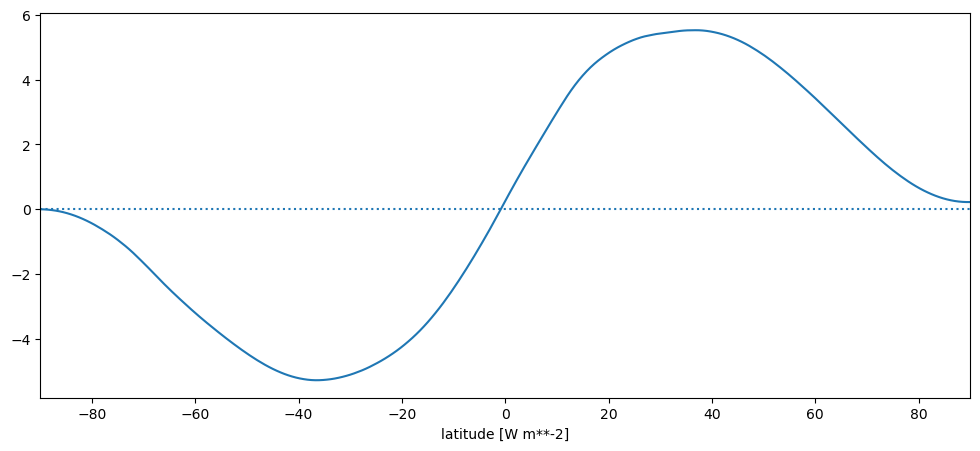

In [13]:
et_toa.plot();
plt.hlines(0, -90, 90, linestyles=':')
plt.xlim([-90, 90]);

**Q: Note that the transport is not zero at the North Pole. Can you guess why? Is this bad?**

## Energy balance at the surface

Now let's compute the energy balance at the surface $E_{Surf}$ as well as its average. Unlike with CERES data, we now have the opportunity to compute all fluxes at the surface (not only the radiative ones):

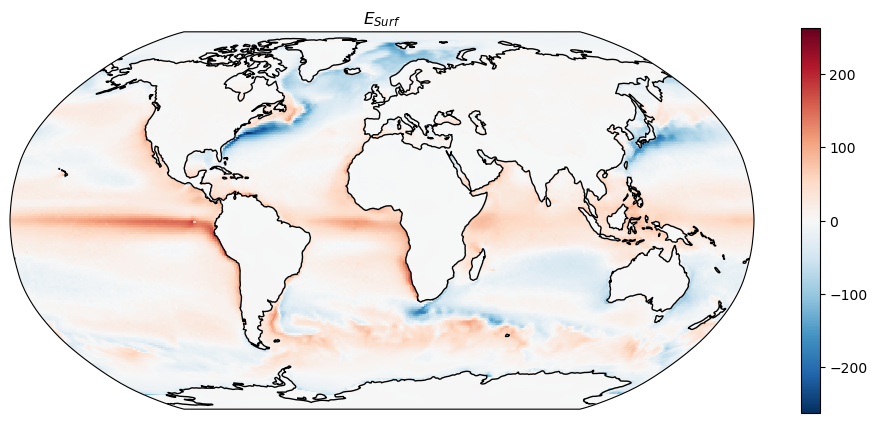

In [14]:
eb_surf = ds.str + ds.ssr + ds.sshf + ds.slhf
ax = plt.axes(projection=ccrs.Robinson())
eb_surf.plot(ax=ax, transform=ccrs.PlateCarree())
plt.title('$E_{Surf}$')
ax.coastlines();

In [15]:
print('Average SW Down: {:.0f} W m-2'.format((ds.ssrd.mean(dim='longitude') * w).sum().data))
print('Average SW UP: {:.0f} W m-2'.format(((ds.ssr - ds.ssrd).mean(dim='longitude') * w).sum().data))
print('Average LW Down: {:.0f} W m-2'.format((ds.strd.mean(dim='longitude') * w).sum().data))
print('Average LW UP: {:.0f} W m-2'.format(((ds.str - ds.strd).mean(dim='longitude') * w).sum().data))
print('Average Sensible HF: {:.0f} W m-2'.format((ds.sshf.mean(dim='longitude') * w).sum().data))
print('Average Latent HF: {:.0f} W m-2'.format((ds.slhf.mean(dim='longitude') * w).sum().data))
print('Average EB Surface: {:.0f} W m-2'.format((eb_surf.mean(dim='longitude') * w).sum().data))

Average SW Down: 188 W m-2
Average SW UP: -24 W m-2
Average LW Down: 339 W m-2
Average LW UP: -397 W m-2
Average Sensible HF: -17 W m-2
Average Latent HF: -83 W m-2
Average EB Surface: 6 W m-2


**Q: Is the surface energy budget balanced? Should it be? Compare the values above with the values we discussed in the lecture. For reference, here is the figure again:**


<img src="http://www.skepticalscience.com/pics/Figure1.png" width="50%">

*Note: errors in reanalysis data are aknowledged and discussed. See for example [this paper](http://onlinelibrary.wiley.com/doi/10.1002/qj.864/pdf) for a discussion with ERA-Interim, the dataset prior to ERA5.*

## Energy balance of the atmosphere

I'll now compute the energy balance of the atmosphere $E_{Atm}$ as the residual of the energy balance at the surface and at the top of the atmosphere (note: this assumes that the entire residual of the surface EB is also taken from the atmosphere):

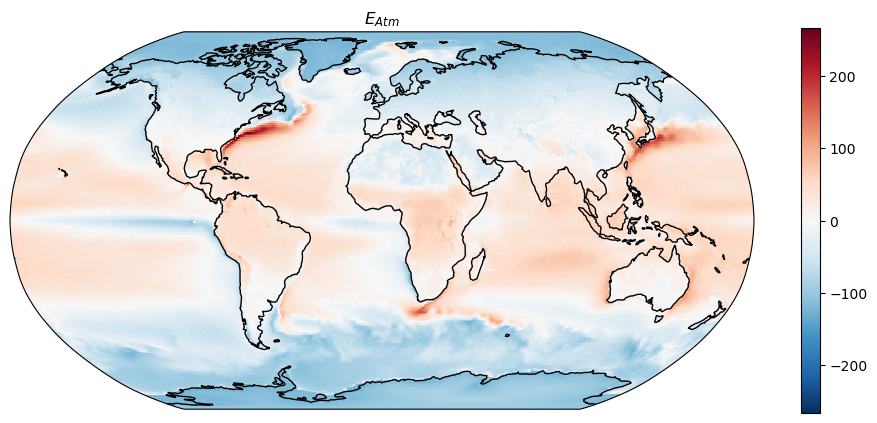

In [16]:
eb_atm = eb_toa - eb_surf
ax = plt.axes(projection=ccrs.Robinson())
eb_atm.plot(ax=ax, transform=ccrs.PlateCarree())
plt.title('$E_{Atm}$')
ax.coastlines();

In [17]:
print('Average E Atm: {:.2f} W m-2'.format((eb_atm.mean(dim='longitude') * w).sum().data))

Average E Atm: -5.73 W m-2


**Q: Is the atmosphere energy budget balanced? Should it be?**

The energy transported by the atmosphere can be computed with the exact same methodology:

$$ ET_{Atm}(\varphi)=\int\limits^{\varphi}_{-\pi/2}\int\limits^{2\pi}_{0} E_{Atm} R^2\cos\varphi'd\lambda d\varphi' $$

Let's compute the energy transport the same way as we did before:

In [18]:
intermediate_eb = (eb_atm * dx_rad).sum(dim='longitude') * r**2 * coslat
et_atm = np.cumsum(intermediate_eb[::-1] * dx_rad, axis=0) / 1e15

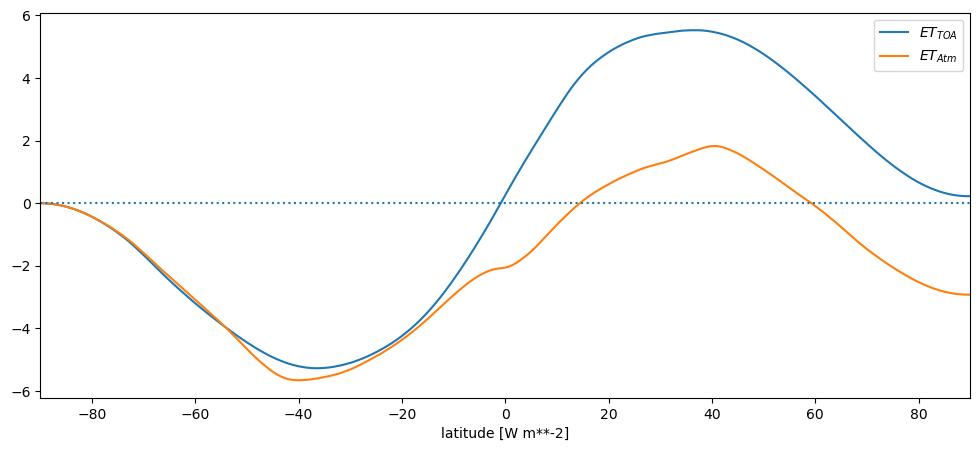

In [19]:
et_toa.plot(label='$ET_{TOA}$')
et_atm.plot(label='$ET_{Atm}$')
plt.hlines(0, -90, 90, linestyles=':')
plt.xlim([-90, 90])
plt.legend();

**Q Are you satisfied with the results? What are the major issues with this plot?**

## Energy transport of the atmosphere and the oceans

To compute the theoretical energy transport, we have to aknowledge that the energy budget has to be closed for the integration to work.

We now apply a bias correction to $E_{TOA}$ and $E_{Atm}$ by substracting the residual of the energy balance closure (so that the budget is balanced):

In [20]:
# Bias corrected TOA Transport
eb_toa_cor = eb_toa - (eb_toa.mean(dim='longitude') * w).sum()
intermediate_eb = (eb_toa_cor * dx_rad).sum(dim='longitude') * r**2 * coslat
et_toa = np.cumsum(intermediate_eb[::-1] * dx_rad, axis=0) / 1e15
# Bias corrected Atm Transport
eb_atm_cor = eb_atm - (eb_atm.mean(dim='longitude') * w).sum()
intermediate_eb = (eb_atm_cor * dx_rad).sum(dim='longitude') * r**2 * coslat
et_atm = np.cumsum(intermediate_eb[::-1] * dx_rad, axis=0) / 1e15

By noting that the total energy transport must be the sum of the transport by the atmosphere and by the oceans we can also compute $ET_{Ocean}$:

In [21]:
et_ocean = et_toa - et_atm

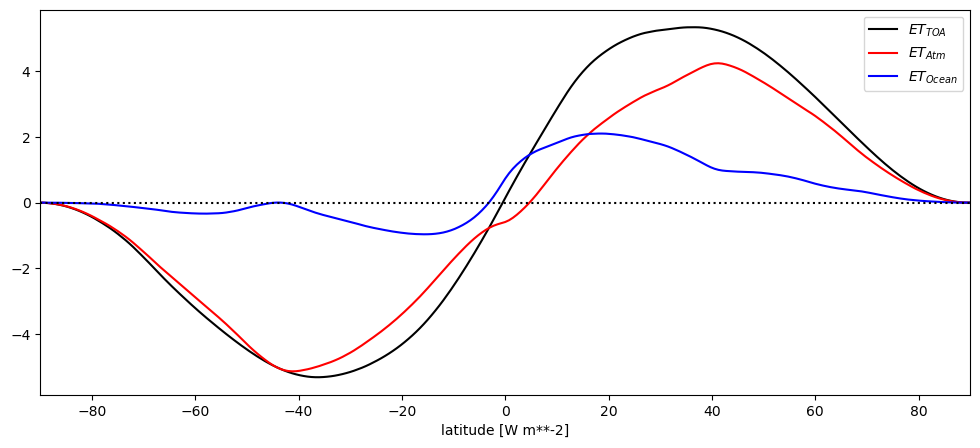

In [22]:
et_toa.plot(label='$ET_{TOA}$', color='k')
et_atm.plot(label='$ET_{Atm}$', color='r')
et_ocean.plot(label='$ET_{Ocean}$', color='b')
plt.hlines(0, -90, 90, linestyles=':', color='k')
plt.xlim([-90, 90])
plt.legend();

**Q: compare it to the plot by Fasullo and Trenberth (2008) that we analysed during the lecture.**

<img src="https://www.dropbox.com/s/2oym6udq1c7x0ns/fasullo_trenberth_2008.png?dl=1" width="50%">

## Add-on: same with CERES data 

In [29]:
ds = xr.open_dataset('../data/CERES_EBAF-TOA_Ed4.1_Clim-2005-2015.nc')
# constants
dx_rad = np.deg2rad(1)
coslat = np.cos(np.deg2rad(ds.lat))
w = coslat / np.sum(coslat)
r = 6371000
# Compute
eb_toa = (ds.solar_clim - ds.toa_sw_all_clim - ds.toa_lw_all_clim).mean(dim='month')
# Correct
eb_toa = eb_toa - (eb_toa.mean(dim='lon') * w).sum()
intermediate_eb = (eb_toa * dx_rad).sum(dim='lon') * r**2 * coslat
et_toa_ceres = np.cumsum(intermediate_eb * dx_rad, axis=0) / 1e15

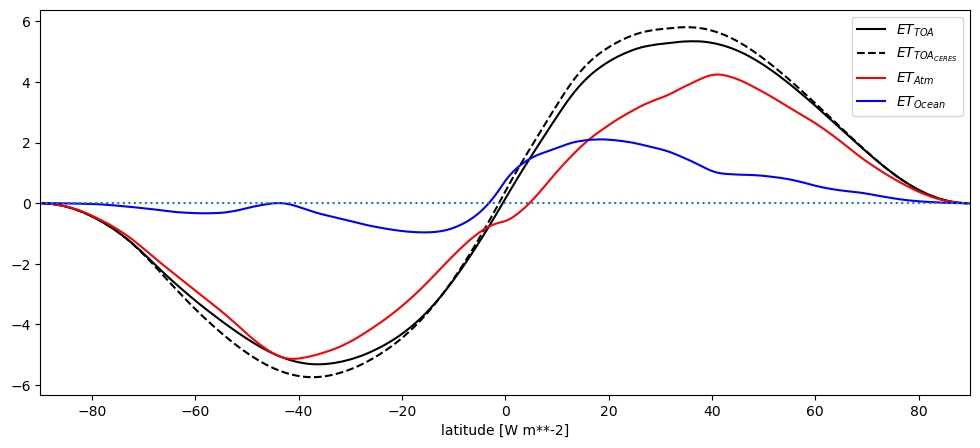

In [31]:
et_toa.plot(label='$ET_{TOA}$', color='k')
et_toa_ceres.plot(label='$ET_{TOA_{CERES}}$', color='k', linestyle='--')
et_atm.plot(label='$ET_{Atm}$', color='r')
et_ocean.plot(label='$ET_{Ocean}$', color='b')
plt.hlines(0, -90, 90, linestyles=':')
plt.xlim([-90, 90])
plt.legend();

## To go further

If you are interested, I recommend you have a look at the various terms of the TOA and surface energy balances and see if you can understand most of the patterns you observe. You can also plot their zonal average and analyse their respective importance according to latitude.